<h1 align='center'>Final assignment of "Laboratory of Computational Physics"</h1>
<img align='right' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' style='width:400px;'/>


<h2 align='left'>Search for flavor-changing neutral currents <br>in $t\bar{t}$ processes in multilepton final states in <br> proton-proton collisions with the CMS detector</h2>


<h3 align='left'>University of Padua - Physics of Data</h3>
<h4 align='left'>Dott. Alberto Zucchetta, Prof. Marco Zanetti</h4>

**Name** | **ID number** | **mail**@studenti.unipd.it
:-:|:-:|-:
Chiara Maccani | 2027591 | chiara.maccani
Samuele Piccinelli | 2027650 | samuele.piccinelli
Tommaso Stentella | 2027586 | tommaso.stentella
Cristina Venturini | 2022461 | cristina.venturini.5

<div class="alert-success">
<h2 align='center'>Extraction of the limit on the branching ratio</h2>
</div>

<a id='index'></a>
### Index

#### 1. [Input variables](#1)
#### 2. [Dataset setup](#2)
#### 3. [Declare data loaders](#3)
#### 4. [Model selection and comparison](#4)
#### 5. [BDT training](#5)
#### 6. [Evaluation of the classifier](#6)
#### 7. [Statistical analysis](#7)
#### 8. [Final results](#8)

In [1]:
# - import libraries and useful dependencies

import ROOT
from ROOT import TMVA
import uproot
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('axes', **{'grid':False,'titlesize':'large','labelsize':'large','unicode_minus':False})
plt.rc('legend',fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

import seaborn as sns

Welcome to JupyROOT 6.24/00


<a id='1'></a>
[Index](#index)
### 1. Input variables

We first load the dataset from the snapshot with the relevant features in `uproot`. The set of input variables considered for the discriminant presented in the tables below with the relative description for the **di-** and **tri-lepton category** respectively.

Variable | Definition
:-:|:-:|
$$\eta_{max}$$ | max. absolute value of the pseudo-rapidity of the 2 leptons
$$\eta_{1}$$ | absolute value of the pseudo-rapidity of the lepton with tag 1
$$m^{inv}$$ | invariant mass of the leptons
$$\Delta R_{hl/J}$$ | angular separation between the highest $p^t$ lepton direction and the axis of the nearest jet in the ($\eta$,$\phi$) plane
$$\Delta R_{ll/J}$$ | angular separation between the lowest $p^t$ lepton direction and the axis of the nearest jet in the ($\eta$,$\phi$) plane
$$\Delta R_{lep}$$ | angular separation between the 2 leptons
$$\Delta\phi_{MET/0}$$ | phase difference between missing transverse energy (MET) and lepton with 0 tag
$$\Delta\phi_{MET/1}$$ | phase difference between MET and lepton with 1 tag

Variable | Definition
:-:|:-:|
$$m^{inv}_{0/1}$$ | invariant mass between lepton with tag 0 and lepton with tag 1
$$m^{inv}_{0/2}$$ | invariant mass between lepton with tag 0 and lepton with tag 2
$$m^{inv}_{1/2}$$ | invariant mass between lepton with tag 1 and lepton with tag 2
$$\Delta R_{1/J}$$ | angular separation between the lepton with tag 1 direction and the axis of the nearest jet in the ($\eta$,$\phi$) plane
$$\Delta R_{0/bJ}$$ | angular separation between the lepton with tag 0 direction and the axis of the nearest b-tagged jet in the ($\eta$,$\phi$) plane
$$\Delta R_{0/1}$$ | angular separation between the lepton with tag 0 direction and the lepton with tag 1 direction in the ($\eta$,$\phi$) plane
$$\Delta R_{0/2}$$ | angular separation between the lepton with tag 0 direction and the lepton with tag 2 direction in the ($\eta$,$\phi$) plane
$$\eta_{1}$$ | absolute value of the pseudo-rapidity of the lepton with tag 1
$$\eta_{2}$$ | absolute value of the pseudo-rapidity of the lepton with tag 2
$$\Delta\phi_{MET/0}$$ | phase difference between missing transverse energy (MET) and lepton with 0 tag
$$\Delta\phi_{MET/1}$$ | phase difference between missing transverse energy (MET) and lepton with 1 tag
$$\Delta\phi_{MET/2}$$ | phase difference between missing transverse energy (MET) and lepton with 2 tag

The set of input variables presented in this section has been constructed and optimized based on the results showed by [M. Aaboud et al.](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.032002) whereas for this second stage a more data-driven approach has been preferred.

We perform a multi-variate analysis by means of the [Toolkit for Multivariate Data Analysis](https://root.cern.ch/download/doc/tmva/TMVAUsersGuide.pdf) (TMVA), which provides a ROOT-integrated framework for the processing and parallel evaluation of many different multivariate classification techniques. The classification is done in terms of two event categories, e.g. signal and background. A method referred to as **Gradient Boosted Decision Trees** (GBDT) is exploited in this study.

The input variables are chosen to have a significant discriminating power - i.e. a visible discrepancy in the histograms between signal and background. To quantify this one could have used the **separation value** defined as
$$\begin{equation}
    \langle s^2 \rangle = \frac{1}{2} \int \frac{[p_s(y)-p_b(y)]^2}{p_s(y)+p_b(y)} dy
\end{equation}
$$
where $p_s(y)$ and $p_b(y)$ are the signal and background PDFs of the classifier $y$. The separation is $0$ ($1$) for identical (non-overlapping) signal and background shapes. However, this variable ranking is later superseded by the ranking provided by the classifier. In fact, TMVA offers convenient preprocessing possibilities for the data prior to feeding them into the classifier. Auxiliary information is provided such as the correlations between the input variables, their separation power and ranking, and efficiency versus background rejection curves for all trained classifiers. These criteria allow the user to choose the optimal classifier for the given problem.

A preliminary ranking of the input variables is provided and their linear correlation coefficients are displayed. It is worth noting that the effects of a low-discriminating-power input variable on the analysis of BDTs methods go from a small performance gain to no gain at all - allowing a more relaxed choice.

In [2]:
dirOutPath = '/data/Skim/'

listDir = os.listdir(dirOutPath)

In [3]:
SignalFlat = [0]*4
MCFlat = [0]*4

for i in range(1,5):
    SignalFlat[i-1] = uproot.open(dirOutPath + 'SignalFlat{}.root:Events'.format(i)).arrays(library='pd')
    MCFlat[i-1] = uproot.concatenate(dirOutPath + 'MC*{}.root:Events'.format(i), allow_missing=True, library='pd')
    
    SignalFlat[i-1]['label'] = 'signal'
    MCFlat[i-1]['label'] = 'bkg'
    
diLepton = pd.concat((SignalFlat[0], SignalFlat[1]))
triLepton = pd.concat((SignalFlat[2], SignalFlat[3]))

diLepton = pd.concat((diLepton, MCFlat[0], MCFlat[1]))
triLepton = pd.concat((triLepton, MCFlat[2], MCFlat[3]))

In [4]:
# drop weights
diLepton = diLepton.drop(columns=['eventWeightLumi'])
triLepton = triLepton.drop(columns=['eventWeightLumi'])

In [5]:
di_corr = diLepton.corr()
tri_corr = triLepton.corr()

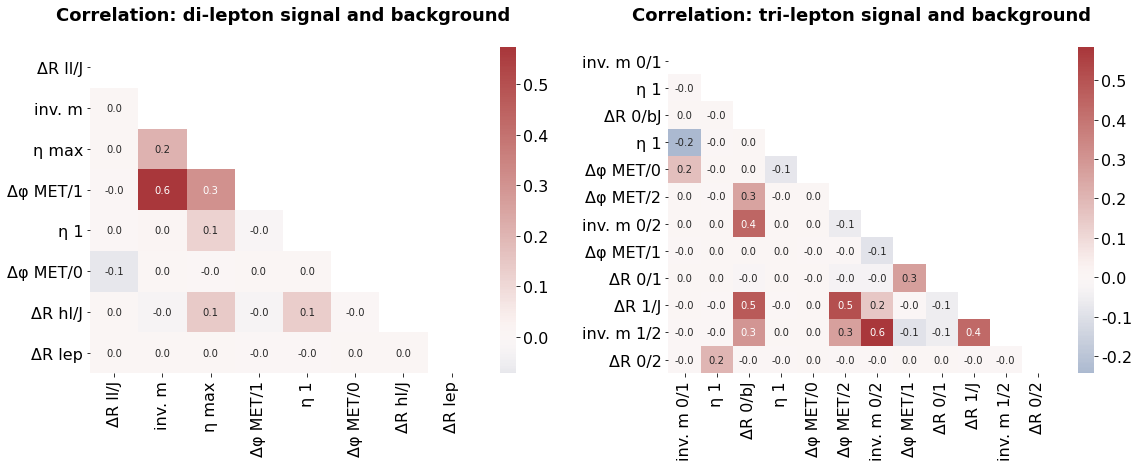

In [6]:
values2 = ['\u0394R ll/J', 'inv. m', '\u03B7 max', '\u0394\u03C6 MET/1',
           '\u03B7 1', '\u0394\u03C6 MET/0', '\u0394R hl/J', '\u0394R lep']
values3 = ['inv. m 0/1', '\u03B7 1', '\u0394R 0/bJ', '\u03B7 1', '\u0394\u03C6 MET/0', '\u0394\u03C6 MET/2',
           'inv. m 0/2', '\u0394\u03C6 MET/1', '\u0394R 0/1', '\u0394R 1/J', 'inv. m 1/2', '\u0394R 0/2']
mask2 = np.zeros_like(di_corr)
mask2[np.triu_indices_from(mask2)] = True
mask3 = np.zeros_like(tri_corr)
mask3[np.triu_indices_from(mask3)] = True

f_corr, (ax_di_corr, ax_tri_corr) = plt.subplots(nrows=1, ncols=2, figsize=(19,6))
ax_di_corr.set_title('Correlation: di-lepton signal and background\n', fontweight='bold', size=18)
tabc_sgn = sns.heatmap(di_corr, center=0, cmap='vlag', annot=True, fmt='.1f', linewidths=0, mask=mask2,
            xticklabels=values2, yticklabels=values2, ax=ax_di_corr)

ax_tri_corr.set_title('Correlation: tri-lepton signal and background\n', fontweight='bold', size=18)
tabc_corr = sns.heatmap(tri_corr, center=0, cmap='vlag', annot=True, fmt='.1f', linewidths=0, mask=mask3,
            xticklabels=values3, yticklabels=values3, ax=ax_tri_corr)

From the correlation matrices above we exclude $\Delta R_{lep}$ and $\Delta R^{0/2}$, $m^{0/2}_{inv}$ for further analysis for the di- and tri-lepton category respectively. Variables like $m^{0/2}_{inv}$ or $\Delta R^{0/2}$ are not excluded despite having a high correlation coefficient, since they posses a high separation ranking (see section [5.](#5)).

All in all, separation values, correlations and impact on the BDT performance are taken into account for the choice of the input variables.

<a id='2'></a>
[Index](#index)
### 2. Dataset setup

The data are loaded in `ROOT.TChain` objects for the ingestion in the BDT and once again grouped by number of leptons in the final state in the di- and tri-lepton category.

In [7]:
def loadData(chain, pathDirs, info=False):
    ROOT.ROOT.EnableImplicitMT()
    for file in pathDirs:
        if info: print('>>> Process directory ', Dir)
        tmp = ROOT.TFile.Open(dirOutPath + file)
        try:
            tmp.Get('Events').GetEntries()
            chain.Add(dirOutPath + file)
        except: continue
            
    return chain

def returnFiles(string, nSkim):
    return [file for file in listDir if (file.startswith(string) and file.endswith(str(nSkim)+'.root'))]

In [8]:
bkg_files2 = returnFiles('MC',1) + returnFiles('MC',2)
bkg_files3 = returnFiles('MC',3) + returnFiles('MC',4)
sig_files2 = returnFiles('Sig',1) + returnFiles('Sig',2)
sig_files3 = returnFiles('Sig',3) + returnFiles('Sig',4)
dat_files2 = returnFiles('Dat',1) + returnFiles('Dat',2)
dat_files3 = returnFiles('Dat',3) + returnFiles('Dat',4)

### Background ###
chain_bkg2 = ROOT.TChain('Events')
chain_bkg2 = loadData(chain_bkg2, bkg_files2)

chain_bkg3 = ROOT.TChain('Events')
chain_bkg3 = loadData(chain_bkg3, bkg_files3)

### Signal ###
chain_sig2 = ROOT.TChain('Events')
chain_sig2 = loadData(chain_sig2, sig_files2)

chain_sig3 = ROOT.TChain('Events')
chain_sig3 = loadData(chain_sig3, sig_files3)

### Data ###
chain_dat2 = ROOT.TChain('Events')
chain_dat2 = loadData(chain_dat2, dat_files2)

chain_dat3 = ROOT.TChain('Events')
chain_dat3 = loadData(chain_dat3, dat_files3)

<a id='3'></a>
[Index](#index)
### 3. Declare data loaders

The next step is to declare the `DataLoader` class that deals with the input variables. The data sets are divided into statistically independent samples of training and testing data with a 80/20 ratio, omitting here an independent validation sample. Individual event weights may be attributed when specified in the data set.

In [9]:
signalWeight     = 1.0
backgroundWeight = 1.0

### LOADER 2 ###
loader2 = ROOT.TMVA.DataLoader('dataset')

loader2.AddSignalTree(chain_sig2, signalWeight)
loader2.AddBackgroundTree(chain_bkg2, backgroundWeight)

var2 = ['max_eta','lep_eta1','inv_m','dRHJ','dRLJ','dPhi0','dPhi1']
for var in var2:
    loader2.AddVariable(var)

### LOADER 3 ###
loader3 = ROOT.TMVA.DataLoader('dataset')

loader3.AddSignalTree(chain_sig3, signalWeight)
loader3.AddBackgroundTree(chain_bkg3, backgroundWeight)

var3 = ['inv_m01','lep_eta1','lep_eta2','inv_m12','dR1J','dR0bJ','dR01','dPhi0','dPhi1','dPhi2']

for var in var3:
    loader3.AddVariable(var)

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Events of type Signal with 9088 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Events of type Background with 162339 events
DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Events of type Signal with 5107 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Events of type Background with 161067 events


In [10]:
void_cut = ROOT.TCut('')

loader2.PrepareTrainingAndTestTree(void_cut, void_cut,
                                  'nTrain_Signal=7270:nTrain_Background=129871:SplitMode=Random:'
                                   'NormMode=NumEvents:!V' )
loader3.PrepareTrainingAndTestTree(void_cut, void_cut,
                                  'nTrain_Signal=4086:nTrain_Background=128854:SplitMode=Random:'
                                   'NormMode=NumEvents:!V' )

<a id='4'></a>
[Index](#index)
### 4. Model selection and comparison

A **decision tree** is a classifier that is structured as a binary tree. For each test event, repeated left/right (yes/no) decisions are performed on a single variable at a time until the event reaches a so called leaf node which classifies it as being either **signal** or **background**. The collection of leaf nodes split the phase space into many disjunct regions that are classified as being either signal- or background-like.

The tree structure is defined during the training (tree building) phase, when starting from the whole training
sample, consecutive binary splits are determined using the variable and cut value that allows maximum separation between signal and background at the time. When the splitting is finished, the node is classified as either signal
or background depending on the majority of training events that end up in it.

In TMVA, the stop criteria for the splitting during the training phase is given by the minimum number of events which is demanded for a leaf node. Small numbers of events in leaf nodes are able to capture small features in the phase space discriminating signal from background. However this may easily result in over-training, i.e. the capture of statistical fluctuations in the training sample rather than genuine features of the underlying PDFs.

In order to understand and tune properly this parameters, the classifiers are then tested and evaluated to assess their performance. The optimal classifier to be used for a specific analysis strongly depends on the problem at hand and no general recommendations can be given. To simplify the choice we choose to vary the number of trees `NTrees` and boost type `BoostType`. Since ROOT 6.08 a support for hyper-parameter tuning for BDT methods is added but no further analysis is carried out due to the high computational cost.

The classification algorithm tested are:

- **AdaBoost**. Short adaptive boosting, its basic idea is to form the aggregate classifier in an iterative process. Importantly, at each iteration the error function is reweighted to "highlight" data points where the aggregate classifier performs poorly - so that in the next round the procedure put more emphasis on making those right.
- **Bagging**. Short for Bootstrap AGGregation, it is a resampling technique where a classifier is repeatedly trained using resampled training events such that the combined classifier represents an average of the individual classifiers.
- **Grad**. It cures the lacks of AdaBoost in robustness in presence of outliers or mislabelled data points starting from the assumption that boosting can interpreted as an optimization algorithm on a suitable cost function.

The statistical measure used is the integral of the ROC curve.

In [11]:
%%capture

outputFileGrid = ROOT.TFile.Open('gridClassification.root', 'RECREATE')

factoryGrid = ROOT.TMVA.Factory('TMVA_Classification', outputFileGrid,
                      '!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification' )

nTrees = [10, 20, 50, 100, 400, 800]
boost = ['AdaBoost', 'Bagging', 'Grad']

for tree in nTrees:
    for boo in boost:
        str2 = 'BDT2_{}_{}'.format(tree,boo)
        str3 = 'BDT3_{}_{}'.format(tree,boo)

        factoryGrid.BookMethod(loader2,ROOT.TMVA.Types.kBDT, str2,
               '!V:NTrees={}:MinNodeSize=2.5%:MaxDepth=3:BoostType={}:'
               'SeparationType=SDivSqrtSPlusB'.format(tree,boo) )

        factoryGrid.BookMethod(loader3,ROOT.TMVA.Types.kBDT, str3,
               '!V:NTrees={}:MinNodeSize=2.5%:MaxDepth=3:BoostType={}:'
               'SeparationType=SDivSqrtSPlusB'.format(tree,boo) )
            
factoryGrid.TrainAllMethods()
factoryGrid.TestAllMethods()
factoryGrid.EvaluateAllMethods()
outputFileGrid.Close()

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       BDT3_20_Grad   : 0.791
                         : dataset       BDT3_50_Grad   : 0.791
                         : dataset       BDT3_10_Grad   : 0.787
                         : dataset       BDT3_100_Grad  : 0.786
                         : dataset       BDT3_400_Grad  : 0.772
                         : dataset       BDT3_800_Grad  : 0.769
                         : dataset       BDT3_400_Bagging: 0.732
                         : dataset       BDT3_800_Bagging: 0.730
                         : dataset       BDT3_100_Bagging: 0.729
                 

The best set of parameters found is for 20 trees and with gradient boosting for both the di- and tri-lepton category. The same set is therefore used for the following analysis.

<a id='5'></a>
[Index](#index)
### 5. BDT training

A `Factory` class organises the interaction between the user and the TMVA analysis steps including preanalysis and preprocessing of the training data. After the training, the classifier writes the entire information needed for its later application to a weight file.

Finally, the ROC curves for the trained methods in both categories are plotted.

In [12]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open('Classification.root', 'RECREATE')

factory = ROOT.TMVA.Factory('TMVA_Classification', outputFile,
                      '!V:ROC:Color:!DrawProgressBar:AnalysisType=Classification' )

In [13]:
factory.BookMethod(loader2,ROOT.TMVA.Types.kBDT, 'BDT2',
                   '!V:NTrees=20:MinNodeSize=2.5%:MaxDepth=3:BoostType=Grad:'
                   'SeparationType=SDivSqrtSPlusB' )

factory.BookMethod(loader3,ROOT.TMVA.Types.kBDT, 'BDT3',
                   '!V:NTrees=20:MinNodeSize=2.5%:MaxDepth=3:BoostType=Grad:'
                   'SeparationType=SDivSqrtSPlusB' )

In [14]:
factory.TrainAllMethods()

In [15]:
factory.TestAllMethods()

In [16]:
factory.EvaluateAllMethods()

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       BDT3           : 0.791
                         : dataset       BDT2           : 0.667
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA    

In [17]:
outputFile.Close()

AUC diLepton:	 0.667
AUC triLepton:	 0.791


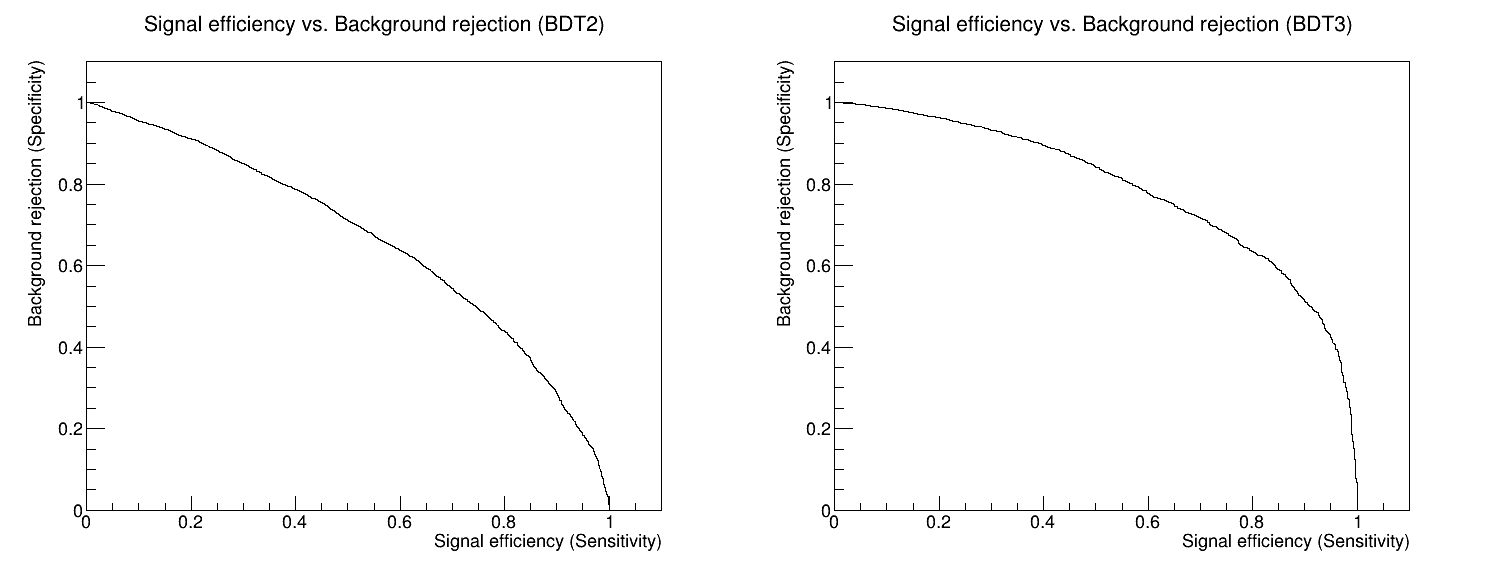

In [18]:
c = ROOT.TCanvas('','',1500,600)
c.Divide(2,1)
c.cd(1)
roc = factory.GetROCCurve(loader2, 'BDT2')
roc.Draw()
print('AUC diLepton:\t', round(factory.GetROCIntegral(loader2, 'BDT2'),3))
c.cd(2)
roc = factory.GetROCCurve(loader3, 'BDT3')
roc.Draw()
print('AUC triLepton:\t', round(factory.GetROCIntegral(loader3, 'BDT3'),3))
c.Draw()

<a id='6'></a>
[Index](#index)
### 6. Evaluation of the classifier

The application of the trained classifiers to the selection of events from a data sample with unknown signal and background composition is handled via a `Reader` object, which reads and interprets the weight file and produces the corresponding output.

In [19]:
read = ROOT.TFile.Open('Classification.root')

In [20]:
from array import array
max_eta = array('f',[0])
lep_eta1 = array('f',[0])
inv_m = array('f',[0])
dRHJ = array('f',[0])
dRLJ = array('f',[0])
dPhi0 = array('f',[0])
dPhi1 = array('f',[0])

reader = TMVA.Reader('evaluation')

reader.AddVariable('max_eta', max_eta)
reader.AddVariable('lep_eta1', lep_eta1)
reader.AddVariable('inv_m', inv_m)
reader.AddVariable('dRHJ', dRHJ)
reader.AddVariable('dRLJ', dRLJ)
reader.AddVariable('dPhi0', dPhi0)
reader.AddVariable('dPhi1', dPhi1)

weightfile = 'dataset/weights/TMVA_Classification_BDT2.weights.xml'

reader.BookMVA('BDT2', weightfile)

d2 = ROOT.TH1D('d2','Classifier Output on Data Events',30,-1,1)
s2 = ROOT.TH1D('s2','Classifier Output on Signal Events',30,-1,1)
b2 = ROOT.TH1D('b2','Classifier Output on Background Events',30,-1,1)

for entry in chain_dat2:
    
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    d2.Fill(output)
    
for entry in chain_sig2:
    
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    s2.Fill(output)
    
for entry in chain_bkg2:
    
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    b2.Fill(output, entry.eventWeightLumi)

                         : Booking "BDT2" of type "BDT" from dataset/weights/TMVA_Classification_BDT2.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Classification_BDT2.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT2" of type: "BDT"


In [21]:
inv_m01 = array('f',[0])
lep_eta1 = array('f',[0])
lep_eta2 = array('f',[0])
inv_m12 = array('f',[0])
dR1J = array('f',[0])
dR0bJ = array('f',[0])
dR01 = array('f',[0])
dPhi0 = array('f',[0])
dPhi1 = array('f',[0])
dPhi2 = array('f',[0])

reader = TMVA.Reader('evaluation')

reader.AddVariable('inv_m01', inv_m01)
reader.AddVariable('lep_eta1', lep_eta1)
reader.AddVariable('lep_eta2', lep_eta2)
reader.AddVariable('inv_m12', inv_m12)
reader.AddVariable('dR1J', dR1J)
reader.AddVariable('dR0bJ', dR0bJ)
reader.AddVariable('dR01', dR01)
reader.AddVariable('dPhi0', dPhi0)
reader.AddVariable('dPhi1', dPhi1)
reader.AddVariable('dPhi2', dPhi2)

weightfile = 'dataset/weights/TMVA_Classification_BDT3.weights.xml'

reader.BookMVA('BDT3', weightfile)

d3 = ROOT.TH1D('d3','Classifier Output on Data Events',30,-1,1)
s3 = ROOT.TH1D('s3','Classifier Output on Signal Events',30,-1,1)
b3 = ROOT.TH1D('b3','Classifier Output on Background Events',30,-1,1)

for entry in chain_dat3:
    
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    d3.Fill(output)
    
for entry in chain_sig3:
    
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    s3.Fill(output)
    
for entry in chain_bkg3:
    
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    b3.Fill(output, entry.eventWeightLumi)

                         : Booking "BDT3" of type "BDT" from dataset/weights/TMVA_Classification_BDT3.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Classification_BDT3.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT3" of type: "BDT"


In [22]:
def plot_bdt(data, sig, bkg):    
    # Styles
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)
    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)
    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)
    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)
    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)
    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')
    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)
    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)
    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    c = ROOT.TCanvas('', '', 600, 600)
    c.cd()
    
    sig.SetLineColor(ROOT.TColor.GetColor('#00A88F'))
    sig.SetLineWidth(3)
    sig.Draw('HIST')
    
    bkg.SetLineColor(2)
    bkg.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
    bkg.SetLineWidth(3)
    bkg.Draw('E2 HIST SAME')
    
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
    data.Draw('E1P SAME')
    
    sig.GetXaxis().SetTitle('BDT discriminant')
    sig.GetYaxis().SetTitle('N_{Events}')
    
     # Add legend
    legend = ROOT.TLegend(0.2, 0.7, 0.5, 0.9)
    legend.SetNColumns(2)
    legend.AddEntry(sig, 'Signal', 'f')
    legend.AddEntry(bkg, 'Background', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    
    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{BDT output}')
    
    return c, legend

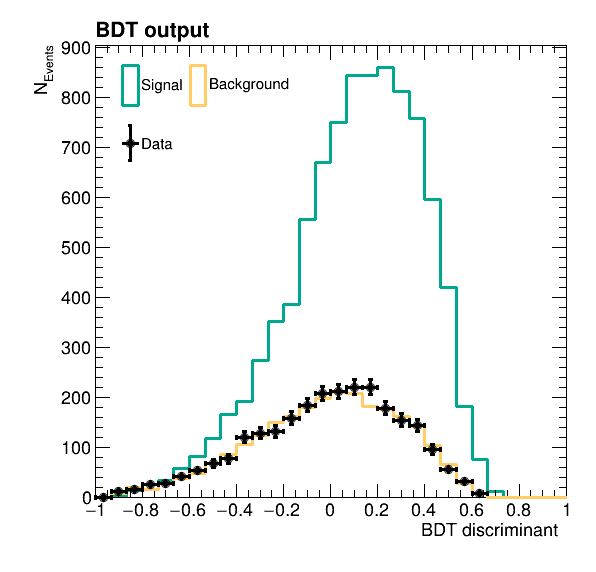

In [23]:
c, l = plot_bdt(d2, s2, b2)
l.Draw()
c.Draw()

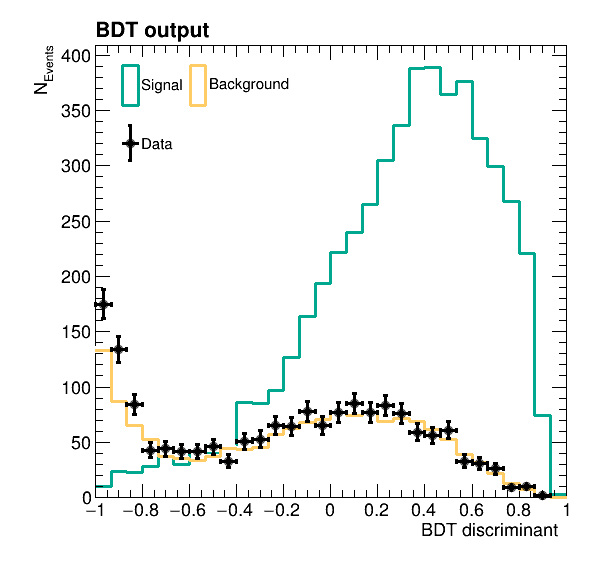

In [24]:
c, l = plot_bdt(d3, s3, b3)
l.Draw()
c.Draw()

The two plots above represent the two discriminat variables produced by the BDT respectively for the di-lepton channel and the tri-lepton one. As expected the distributions of data and background are qualitatively very similar to each other, while the distribution of signal has a different shape from the other two (the normalization in this case is arbitrary, the strength of the signal having to be estimated yet). This is is more evident in the case of the tri-lepton categories, which enjoy a bigger (and with higher separation values) set of initial discriminant variables. This difference between the two is further corroborated by observing the Integral Under Curve of the ROC.

<a id='7'></a>
[Index](#index)
### 7. Statistical analysis

The statistical analysis is in charge of extracting the upper limit on the strength of the signal from the discriminant variables produced by the BDT. The procedure is briefly summarized in the following steps:

1. A likelihood is built considering every bin as independent from the others, so that the complete likelihood can be written as the product of the single-bin likelihoods. The choosen model is a simple poisson distribution with mean equal to the bin count (nuisance parameters coming from the modeling of systematic uncertainties are ignored). The data (so the counts in the data bins) are assumed to be described by a model with mean composed by background and a signal of strength $\mu$ (that is a multiplicative factor of the signal). Calling $n$ the data counts, $b$ the background counts and $s$ the signal ones, the likelihood takes the following form:

$$
\mathcal{L}\,(n|b+\mu s) = \Pi^{n_{\text{bins}}}\, \text{Poi}\,(n|b+\mu s)
$$

2. The likelihood is maximized with respect to the parameter $\mu$, this yelds $\hat{\mu}$. This parameter is assumed to be the best descriptor of the data and is used as a reference point, i.e. normalization factor, in the subsequent comparison between the hypothesis $H_0$ (i.e. background only) and $H_1$ (i.e. signal of strength $\mu$).

3. Taking a given $\mu$ the ratio $q(\mu)_{\text{obs}} = \frac{\mathcal{L}\,(n|b+\mu s)}{\mathcal{L}\,(n|b+\hat{\mu} s)}$ is computed. Toys data are generated with poisson distributions centered on bins counts of signal of strength $\mu$ (i.e. using a mean equal to $b+\mu s$) and are denoted as $n_{\text{toys}}$. These are used to compute the ratios between the two distributions (sampling from them) to be compared and the reference one, that is respectively for $H_0$ and $H_1$:

$$
H_0:
\quad
q(\mu)_0 = \frac{\mathcal{L}\,(n_{\text{toys}}|b)}{\mathcal{L}\,(n_{\text{toys}}|b+\hat{\mu} s)}
\qquad\qquad
H_1:
\quad
q(\mu)_1 = \frac{\mathcal{L}\,(n_{\text{toys}}|b+\mu s)}{\mathcal{L}\,(n_{\text{toys}}|b+\hat{\mu} s)}
$$

4. Taking the distributions $f(q(\mu)_0|b)$ and $f(q(\mu)_1|b,\mu)$ sampled before the following two integral are computed:

$$
H_0:
\quad
p_{\mu} = \int_{q(\mu)_{\text{obs}}}^\infty f(q(\mu)_0|b)
\qquad\qquad
H_1:
\quad
1-p_b = \int_{q(\mu)_{\text{obs}}}^\infty f(q(\mu)_1|b,\mu)
$$

5. The procedure of points 3 and 4 is repeated varying the injected value of $\mu$ until the value of $CL=\frac{p_{\mu}}{1-p_b}$ is equal to $0.05$. The value of $\mu$ that satisfies this condition is the upper limit on the signal strength at $95\%$ confidence level.

6. Finally the significance is the number of standard deviations such that a gaussian has a tail area equal to $1-p_b$. If $z$ is the significance, $p_0 = \int^{+\infty}_z \mathcal{N}(0,1)dx$.

For what concerns the code, a grid for the values of $\mu$ is defined in order to make an approximated optimization.
To evaluate the likelihood on the grid in a vectorized way a matrix of the bin counts is created. The data are repeated as they are for every value of $\mu$ by means of `np.tile`, so they constitute a matrix of `nbins` rows and `len(mu_grid)` columns all equals to one another. The parameter of the poisson is a matrix of nbins rows which has again `len(mu_grid)` columns. In this case every column is different as it is given by bins $b+\mu\cdot sig$ over the changing values of $\mu$.

In the first lines a small negative count value is present in the background histogram, maybe due to some approximation in the MC events weights. It is then approximated to zero. In the extraction of toys the use of ntoys set of bins all equals is only due to the functioning of `ps.rvs`. The mean of the extraction is in fact constant for every bin.

In [35]:
import scipy as sp
from scipy.stats import poisson as ps

def stat(data_hist, sig_hist, bkg_hist):
    
    np.random.seed(12345)
    
    nbins, data, sig, bkg = 0, [], [], []
    
    for d,s,b in zip(data_hist,sig_hist,bkg_hist):

        tmp_bins = d.GetXaxis().GetNbins()
        data  += [d.GetBinContent(i) for i in range(1, tmp_bins+1)]
        sig   += [s.GetBinContent(i) for i in range(1, tmp_bins+1)]
        bkg   += [b.GetBinContent(i) for i in range(1, tmp_bins+1)]
        nbins += tmp_bins
               
    data, sig, bkg = np.array(data), np.array(sig), np.array(bkg)
    data[data<0], sig[sig<0], bkg[bkg<0] = 0, 0, 0
    
    mu_grid = np.arange(0, 0.1, 1e-6)
    
    b_plus_sig = np.outer(sig, mu_grid) + np.tile(bkg,(len(mu_grid),1)).T
    
    like_grid = np.prod(ps.pmf(np.tile(data,(len(mu_grid),1)).T, b_plus_sig), axis=0)
    mu_best = mu_grid[np.argmax(like_grid)]
    b_plus_sig_best = bkg + sig*mu_best
      
    ntoys = int(1e6)
    bin_toys = int(1e3)
    
    mu_min = 0.010
    mu_max = 0.012

    for i in range(30):
        mu = (mu_min+mu_max)/2
        
        b_plus_sig_mu = bkg + sig*mu
        toys = ps.rvs(np.tile(b_plus_sig_mu,(ntoys,1)).T, size=(nbins,ntoys))
        
        like_num0 = np.prod(ps.pmf(toys, np.tile(bkg,(ntoys,1)).T), axis=0)
        like_num1 = np.prod(ps.pmf(toys, np.tile(b_plus_sig_mu,(ntoys,1)).T), axis=0)
        like_den = np.prod(ps.pmf(toys, np.tile(b_plus_sig_best,(ntoys,1)).T), axis=0)
    
        q_mu0 = -2 * np.log(like_num0/like_den)
        q_mu1 = -2 * np.log(like_num1/like_den)
        
        like_num_obs = np.prod(ps.pmf(data, b_plus_sig_mu))
        like_den_obs = np.prod(ps.pmf(data, b_plus_sig_best))
        q_mu_obs = -2 * np.log(like_num_obs/like_den_obs)
        
        ### H0 ###
        values_0, bins_0, _ = plt.hist(q_mu0, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_0 > q_mu_obs)
        p_b = sum(np.diff(bins_0[mask])*values_0[mask[:-1]])
        
        ### H1 ###
        values_1, bins_1, _ = plt.hist(q_mu1, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_1 > q_mu_obs)
        p_mu = sum(np.diff(bins_1[mask])*values_1[mask[:-1]])
        
        if p_b == 0:
            mu_max = mu
            continue
        
        CL = p_mu/p_b
        
        if CL < 0.05: mu_max = mu
        else: mu_min = mu
            
    significance = abs(sp.stats.norm.ppf(p_b))
    
    plt.figure(figsize=(8, 5))
    plt.hist(q_mu0, bins=bin_toys, alpha=0.5, color='red', density=True, label='$H_0$')
    plt.hist(q_mu1, bins=bin_toys, alpha=0.5, color='blue', density=True, label='$H_1$')
    plt.ylim((0,0.15))
    plt.axvline(q_mu_obs, color='#00A88F', label='$q^{obs}(\mu)$')
    plt.title(r'Distributions of $q(\mu)_0$ and $q(\mu)_1$')
    plt.xlabel(r'$q(\mu)$', size=16)
    plt.legend(frameon=False)
    plt.show()
        
    return mu_best, mu, CL, significance

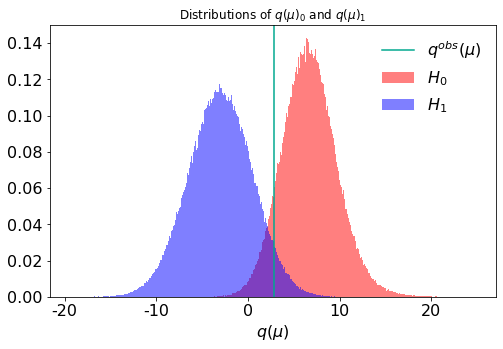

In [36]:
mu_hat, upper_lim, CL, sig = stat((d2,d3), (s2,s3), (b2,b3))

<a id='8'></a>
[Index](#index)
### 8. Final results

In [37]:
print('value of \u03BC maximizing \u2112:\t',round(mu_hat,4))
print('inferred upper limit of \u03BC:\t',round(upper_lim,4))
print('CL:\t\t\t\t',round(CL,4))
print('significance:\t\t\t',round(sig,4))

value of μ maximizing ℒ:	 0.0049
inferred upper limit of μ:	 0.0112
CL:				 0.0497
significance:			 1.3211


<img align='right' src='https://raw.githubusercontent.com/TommasoStentella/LCP_B-CMS_FCNC/master/Plots/inv_m01_final_histogram_3.png' alt='Drawing' style='width:450px;'/>
<img align='left' src='https://raw.githubusercontent.com/TommasoStentella/LCP_B-CMS_FCNC/master/Plots/MET_pt_final_histogram_3.png' alt='Drawing' style='width:450px;'/>